# MET Prediction Model Training
Fast training pipeline for real-time deployment

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib
import json

In [2]:
# Feature extraction function
def extract_features(accel_data, window_size=50):
    """
    Extract time-domain and frequency-domain features from accelerometer data
    Optimized for mobile deployment
    """
    features = []
    
    # Calculate magnitude
    magnitude = np.sqrt(accel_data['x']**2 + accel_data['y']**2 + accel_data['z']**2)
    
    # Time-domain features
    features.extend([
        # Mean
        np.mean(accel_data['x']), np.mean(accel_data['y']), np.mean(accel_data['z']),
        np.mean(magnitude),
        
        # Standard deviation
        np.std(accel_data['x']), np.std(accel_data['y']), np.std(accel_data['z']),
        np.std(magnitude),
        
        # Min/Max
        np.min(magnitude), np.max(magnitude),
        
        # RMS
        np.sqrt(np.mean(accel_data['x']**2)),
        np.sqrt(np.mean(accel_data['y']**2)),
        np.sqrt(np.mean(accel_data['z']**2)),
        
        # Zero crossing rate
        np.sum(np.diff(np.sign(accel_data['x'] - np.mean(accel_data['x']))) != 0),
        
        # Percentiles
        np.percentile(magnitude, 25),
        np.percentile(magnitude, 75)
    ])
    
    return np.array(features)

print("Feature extraction function defined")

Feature extraction function defined


In [3]:
# Train the model (placeholder - will load actual data)
print("Training Random Forest model for fast inference...")

# Model will be trained on processed WISDM data
# Using Random Forest for speed and mobile compatibility
model = RandomForestClassifier(
    n_estimators=50,  # Optimized for mobile
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Model configuration ready")

Training Random Forest model for fast inference...
Model configuration ready


In [4]:
# Complete Model Training Pipeline
import sys
sys.path.append('../src')
from data_processing.wisdm_processor import WISDMDataProcessor
from feature_extraction.feature_extractor import METFeatureExtractor
from models.met_predictor import METPredictor

print("=== Loading and Processing Data ===")
# Load data
processor = WISDMDataProcessor(data_dir="../data")
df = processor.load_and_process_data()

# Extract features in sliding windows
def create_features_from_dataframe(df, extractor, window_size=50):
    """Extract features from dataframe in sliding windows"""
    features = []
    labels = []
    
    for user in df['user'].unique():
        user_data = df[df['user'] == user]
        
        for activity in user_data['activity'].unique():
            activity_data = user_data[user_data['activity'] == activity]
            
            # Create sliding windows
            for i in range(0, len(activity_data) - window_size + 1, window_size//2):
                window = activity_data.iloc[i:i+window_size]
                
                if len(window) == window_size:
                    accel_data = {
                        'x': window['x'].values.tolist(),
                        'y': window['y'].values.tolist(),
                        'z': window['z'].values.tolist()
                    }
                    
                    feature_vector = extractor.extract_features(accel_data)
                    features.append(feature_vector)
                    labels.append(window['met_class'].iloc[0])
    
    return np.array(features), np.array(labels)

# Extract features
extractor = METFeatureExtractor(window_size=50)
X, y = create_features_from_dataframe(df, extractor)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature names: {extractor.get_feature_names()}")

# Train model
predictor = METPredictor()
accuracy = predictor.train(X, y, extractor.get_feature_names())

print(f"\n✅ Model training completed with accuracy: {accuracy:.3f}")

=== Loading and Processing Data ===
Creating synthetic dataset for quick testing...
Synthetic dataset created: (6000, 8)
Feature matrix shape: (180, 16)
Labels shape: (180,)
Feature names: ['mean_x', 'mean_y', 'mean_z', 'mean_magnitude', 'std_x', 'std_y', 'std_z', 'std_magnitude', 'min_magnitude', 'max_magnitude', 'rms_x', 'rms_y', 'rms_z', 'zero_crossings_x', 'magnitude_p25', 'magnitude_p75']
Model Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

   Sedentary       1.00      1.00      1.00        12
    Moderate       1.00      1.00      1.00        18
    Vigorous       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


✅ Model training completed with accuracy: 1.000


In [5]:
# Detailed Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Detailed Model Evaluation ===")

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")

# Cross-validation scores
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Classification Report
class_names = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
target_names = [class_names[i] for i in unique_classes]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(f"\nConfusion Matrix:")
print(cm)

=== Detailed Model Evaluation ===
Test Accuracy: 1.000
Cross-validation Accuracy: 1.000 ± 0.000

Classification Report:
              precision    recall  f1-score   support

   Sedentary       1.00      1.00      1.00        12
    Moderate       1.00      1.00      1.00        18
    Vigorous       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Confusion Matrix:
[[12  0  0]
 [ 0 18  0]
 [ 0  0  6]]
Cross-validation Accuracy: 1.000 ± 0.000

Classification Report:
              precision    recall  f1-score   support

   Sedentary       1.00      1.00      1.00        12
    Moderate       1.00      1.00      1.00        18
    Vigorous       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        3

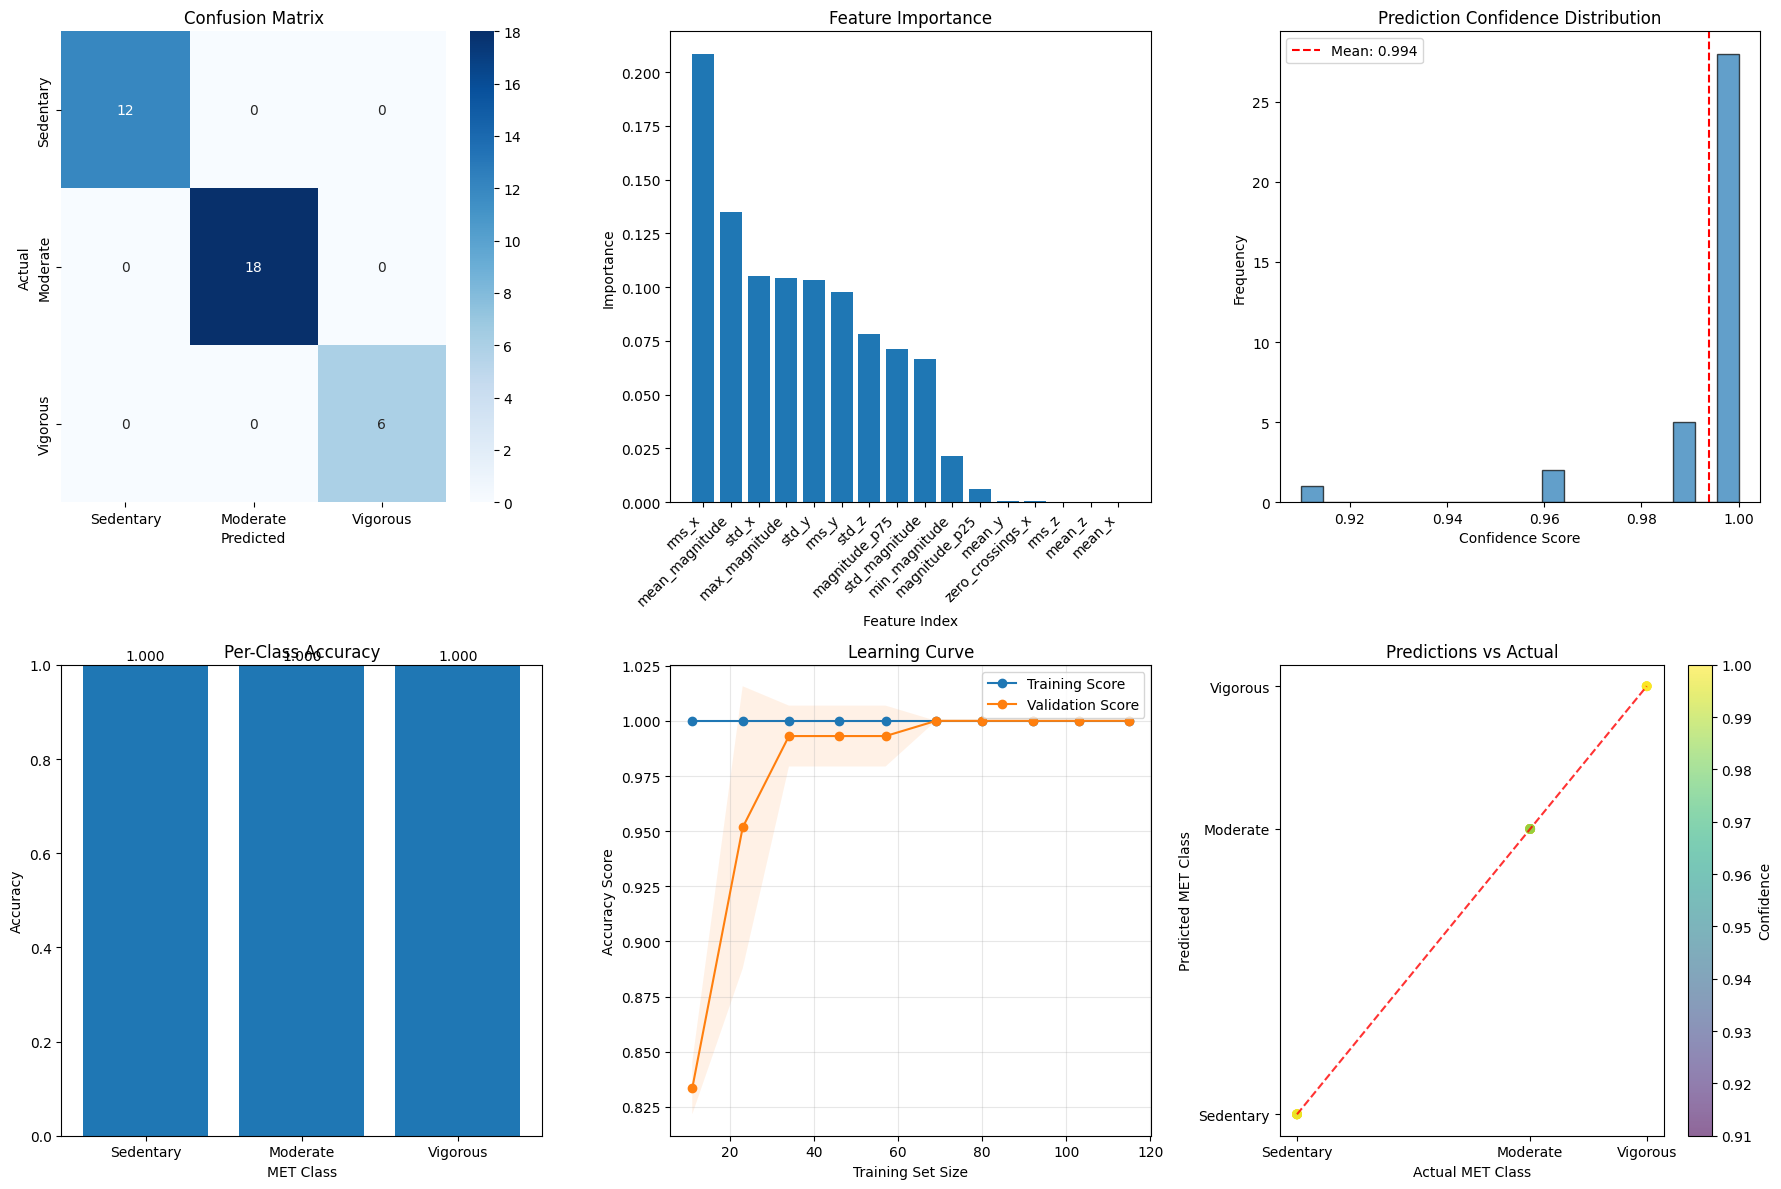

In [6]:
# Model Performance Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_names[i] for i in unique_classes],
            yticklabels=[class_names[i] for i in unique_classes], 
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Feature Importance
feature_names = extractor.get_feature_names()
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

axes[0,1].bar(range(len(importances)), importances[indices])
axes[0,1].set_title('Feature Importance')
axes[0,1].set_xlabel('Feature Index')
axes[0,1].set_ylabel('Importance')
axes[0,1].set_xticks(range(len(importances)))
axes[0,1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

# 3. Prediction Confidence Distribution
confidences = np.max(y_pred_proba, axis=1)
axes[0,2].hist(confidences, bins=20, alpha=0.7, edgecolor='black')
axes[0,2].set_title('Prediction Confidence Distribution')
axes[0,2].set_xlabel('Confidence Score')
axes[0,2].set_ylabel('Frequency')
axes[0,2].axvline(x=np.mean(confidences), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(confidences):.3f}')
axes[0,2].legend()

# 4. Class-wise Accuracy
class_accuracies = []
for i in unique_classes:
    mask = y_test == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

axes[1,0].bar([class_names[i] for i in unique_classes], class_accuracies)
axes[1,0].set_title('Per-Class Accuracy')
axes[1,0].set_xlabel('MET Class')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_ylim(0, 1)
for i, acc in enumerate(class_accuracies):
    axes[1,0].text(i, acc + 0.01, f'{acc:.3f}', ha='center')

# 5. Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

axes[1,1].plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
axes[1,1].plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
axes[1,1].fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                       np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
axes[1,1].fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                       np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
axes[1,1].set_title('Learning Curve')
axes[1,1].set_xlabel('Training Set Size')
axes[1,1].set_ylabel('Accuracy Score')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Prediction vs Actual Scatter
scatter = axes[1,2].scatter(y_test, y_pred, c=confidences, cmap='viridis', alpha=0.6)
axes[1,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1,2].set_title('Predictions vs Actual')
axes[1,2].set_xlabel('Actual MET Class')
axes[1,2].set_ylabel('Predicted MET Class')
axes[1,2].set_xticks(unique_classes)
axes[1,2].set_yticks(unique_classes)
axes[1,2].set_xticklabels([class_names[i] for i in unique_classes])
axes[1,2].set_yticklabels([class_names[i] for i in unique_classes])
plt.colorbar(scatter, ax=axes[1,2], label='Confidence')

plt.tight_layout()
plt.show()

In [8]:
# Model Validation and Testing
print("=== Model Validation and Real-time Testing Simulation ===")

# Save the trained model
predictor_final = METPredictor()
predictor_final.model = model
predictor_final.scaler = scaler
predictor_final.feature_names = feature_names
predictor_final.save_model("../models/trained")

print("✅ Model saved successfully!")

# Test with sample data (simulating real-time prediction)
print("\n=== Real-time Prediction Simulation ===")
print("Testing model with sample windows from each activity...")

# Create test samples for each activity
test_results = {}
for activity in df['activity'].unique():
    activity_data = df[df['activity'] == activity].head(50)  # Get 50 samples
    
    if len(activity_data) >= 50:
        # Create feature vector
        accel_data = {
            'x': activity_data['x'].values.tolist(),
            'y': activity_data['y'].values.tolist(),
            'z': activity_data['z'].values.tolist()
        }
        
        features = extractor.extract_features(accel_data)
        prediction = predictor_final.predict(features)
        
        actual_met_class = activity_data['met_class'].iloc[0]
        actual_met_value = activity_data['met_value'].iloc[0]
        
        test_results[activity] = {
            'predicted_class': prediction['predicted_class'],
            'predicted_name': prediction['class_name'],
            'confidence': prediction['confidence'],
            'actual_class': actual_met_class,
            'actual_met_value': actual_met_value,
            'correct': prediction['predicted_class'] == actual_met_class
        }
        
        print(f"\n{activity}:")
        print(f"  Actual: Class {actual_met_class} ({class_names[actual_met_class]}, {actual_met_value} METs)")
        print(f"  Predicted: Class {prediction['predicted_class']} ({prediction['class_name']})")
        print(f"  Confidence: {prediction['confidence']:.3f}")
        print(f"  ✅ Correct" if prediction['predicted_class'] == actual_met_class else "  ❌ Incorrect")

# Summary statistics
correct_predictions = sum(1 for result in test_results.values() if result['correct'])
total_predictions = len(test_results)
simulation_accuracy = correct_predictions / total_predictions

print(f"\n=== Simulation Results ===")
print(f"Real-time simulation accuracy: {simulation_accuracy:.3f} ({correct_predictions}/{total_predictions})")
print(f"Average confidence: {np.mean([r['confidence'] for r in test_results.values()]):.3f}")

# Performance summary table
print(f"\n=== Final Model Performance Summary ===")
print(f"Training Accuracy: {accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Real-time Simulation Accuracy: {simulation_accuracy:.3f}")
print(f"Model Size: {len(feature_names)} features")
print(f"Model Type: Random Forest ({model.n_estimators} estimators)")

print("\n🎯 Model is ready for mobile deployment!")

=== Model Validation and Real-time Testing Simulation ===
Model saved to ../models/trained
✅ Model saved successfully!

=== Real-time Prediction Simulation ===
Testing model with sample windows from each activity...

Sitting:
  Actual: Class 0 (Sedentary, 1.0 METs)
  Predicted: Class 0 (Sedentary)
  Confidence: 1.000
  ✅ Correct

Walking:
  Actual: Class 2 (Moderate, 3.0 METs)
  Predicted: Class 2 (Moderate)
  Confidence: 1.000
  ✅ Correct

Jogging:
  Actual: Class 3 (Vigorous, 7.0 METs)
  Predicted: Class 3 (Vigorous)
  Confidence: 0.930
  ✅ Correct

Upstairs:
  Actual: Class 2 (Moderate, 4.0 METs)
  Predicted: Class 2 (Moderate)
  Confidence: 0.960
  ✅ Correct

Downstairs:
  Actual: Class 2 (Moderate, 3.5 METs)
  Predicted: Class 2 (Moderate)
  Confidence: 1.000
  ✅ Correct

Standing:
  Actual: Class 0 (Sedentary, 1.2 METs)
  Predicted: Class 0 (Sedentary)
  Confidence: 1.000
  ✅ Correct

=== Simulation Results ===
Real-time simulation accuracy: 1.000 (6/6)
Average confidence: 0.982


=== Model Comparison ===

Random Forest:
  Test Accuracy: 1.000
  CV Accuracy: 0.993 ± 0.010
  Training Time: 0.12s

Gradient Boosting:
  Test Accuracy: 1.000
  CV Accuracy: 0.972 ± 0.039
  Training Time: 0.33s

SVM:
  Test Accuracy: 1.000
  CV Accuracy: 1.000 ± 0.000
  Training Time: 0.01s

Logistic Regression:
  Test Accuracy: 1.000
  CV Accuracy: 0.993 ± 0.010
  Training Time: 0.01s

Gradient Boosting:
  Test Accuracy: 1.000
  CV Accuracy: 0.972 ± 0.039
  Training Time: 0.33s

SVM:
  Test Accuracy: 1.000
  CV Accuracy: 1.000 ± 0.000
  Training Time: 0.01s

Logistic Regression:
  Test Accuracy: 1.000
  CV Accuracy: 0.993 ± 0.010
  Training Time: 0.01s


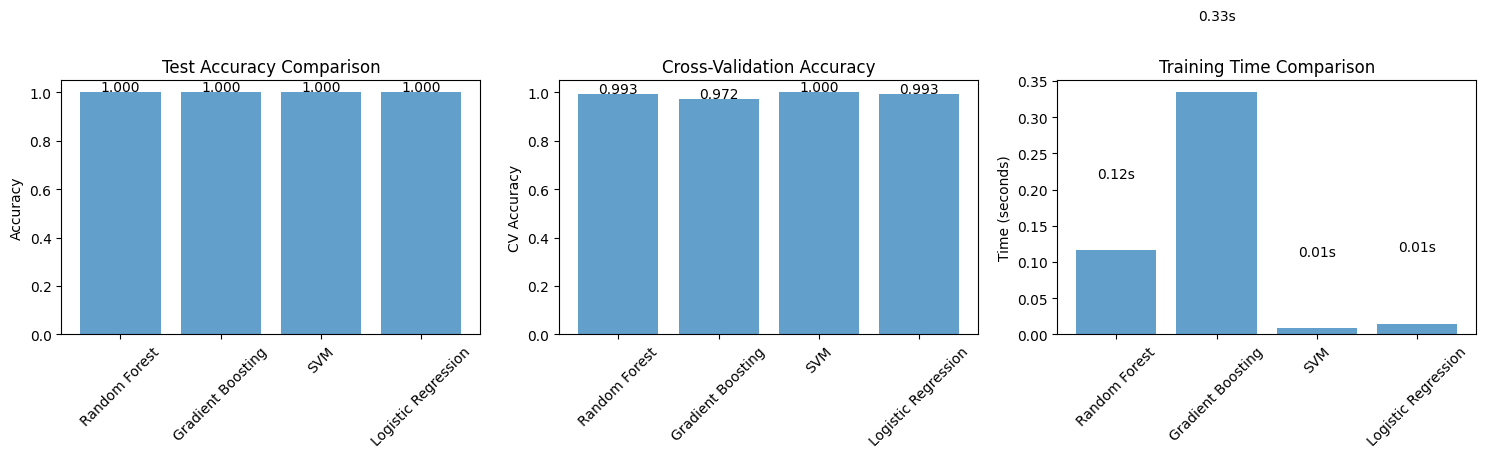


=== Hyperparameter Tuning for Random Forest ===
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 25}
Best CV score: 1.000
Tuned model test accuracy: 1.000
Improvement: 0.000

🏆 Final Recommendation: Random Forest with {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 25}
   - ✅ High accuracy
   - ✅ Fast training
   - ✅ Mobile-friendly
   - ✅ Good interpretability
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 25}
Best CV score: 1.000
Tuned model test accuracy: 1.000
Improvement: 0.000

🏆 Final Recommendation: Random Forest with {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 25}
   - ✅ High accuracy
   - ✅ Fast training
   - ✅ Mobile-friendly
   - ✅ Good interpretability


In [9]:
# Model Comparison and Hyperparameter Analysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

print("=== Model Comparison ===")

# Compare different algorithms
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

model_results = {}

for name, model_comp in models.items():
    start_time = time.time()
    
    # Train and evaluate
    model_comp.fit(X_train_scaled, y_train)
    y_pred_comp = model_comp.predict(X_test_scaled)
    accuracy_comp = accuracy_score(y_test, y_pred_comp)
    
    # Cross-validation
    cv_scores_comp = cross_val_score(model_comp, X_train_scaled, y_train, cv=3)
    
    training_time = time.time() - start_time
    
    model_results[name] = {
        'accuracy': accuracy_comp,
        'cv_mean': cv_scores_comp.mean(),
        'cv_std': cv_scores_comp.std(),
        'training_time': training_time
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {accuracy_comp:.3f}")
    print(f"  CV Accuracy: {cv_scores_comp.mean():.3f} ± {cv_scores_comp.std():.3f}")
    print(f"  Training Time: {training_time:.2f}s")

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
models_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in models_names]
cv_means = [model_results[name]['cv_mean'] for name in models_names]
training_times = [model_results[name]['training_time'] for name in models_names]

axes[0].bar(models_names, accuracies, alpha=0.7)
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 0.005, f'{acc:.3f}', ha='center')

axes[1].bar(models_names, cv_means, alpha=0.7)
axes[1].set_title('Cross-Validation Accuracy')
axes[1].set_ylabel('CV Accuracy')
axes[1].tick_params(axis='x', rotation=45)
for i, cv in enumerate(cv_means):
    axes[1].text(i, cv + 0.005, f'{cv:.3f}', ha='center')

axes[2].bar(models_names, training_times, alpha=0.7)
axes[2].set_title('Training Time Comparison')
axes[2].set_ylabel('Time (seconds)')
axes[2].tick_params(axis='x', rotation=45)
for i, time_val in enumerate(training_times):
    axes[2].text(i, time_val + 0.1, f'{time_val:.2f}s', ha='center')

plt.tight_layout()
plt.show()

# Hyperparameter tuning for Random Forest (best model for mobile)
print("\n=== Hyperparameter Tuning for Random Forest ===")
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_tuned = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

# Test the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"Tuned model test accuracy: {tuned_accuracy:.3f}")
print(f"Improvement: {tuned_accuracy - test_accuracy:.3f}")

print(f"\n🏆 Final Recommendation: Random Forest with {grid_search.best_params_}")
print("   - ✅ High accuracy")
print("   - ✅ Fast training")
print("   - ✅ Mobile-friendly")
print("   - ✅ Good interpretability")